In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re

In [2]:
df = pd.read_csv('pdf_info_with_features.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5295 entries, 0 to 5294
Columns: 132 entries, file_name to page_level_vector_graphics_obj_count_page8
dtypes: bool(1), float64(124), int64(2), object(5)
memory usage: 5.3+ MB


/var/folders/8h/qygchvl97sd_mr0kglftbvp80000gn/T/ipykernel_22719/3467240165.py:1: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('pdf_info_with_features.csv')


In [3]:
metadata_columns = ['file_name', 'old_path', 'ocr_probability', 'file_size_bytes',
                    'file_size_MB', 'size_bucket', 'need_ocr_old_threshold', 'page_count']
feature_columns = [col for col in df.columns if col not in metadata_columns]
doc_level_features = [
        "num_pages_successfully_sampled",
        "garbled_text_ratio",
        "is_form",
        "creator_or_producer_is_known_scanner"
    ]
page_level_features = [
    col for col in df.columns if col.startswith('page_level_')]
len(page_level_features)

print(f"Number of metadata columns: {len(metadata_columns)}")
print(f"Number of feature columns: {len(feature_columns)}")
print(f"Number of document-level features: {len(doc_level_features)}")
print(f"Number of page-level features: {len(page_level_features)}")

Number of metadata columns: 8
Number of feature columns: 124
Number of document-level features: 4
Number of page-level features: 120


In [4]:
page_level_base = sorted({
    re.sub(r"^page_level_|_page\d+$", "", c)
    for c in page_level_features
    if re.search(r"_page\d+$", c)
})

# 预期长度 15
print(page_level_base)

['avg_text_box_lengths', 'bitmap_proportions', 'char_counts', 'drawing_strokes_count', 'hidden_avg_text_box_lengths', 'hidden_char_counts', 'hidden_text_area_ratios', 'hidden_text_box_counts', 'image_counts', 'max_merged_strip_areas', 'non_junk_image_counts', 'text_area_ratios', 'text_box_counts', 'unique_font_counts', 'vector_graphics_obj_count']


In [5]:
bases = page_level_base          # 15 个基础特征名（无前缀/页号）
max_pages = 8
page_available = df["num_pages_successfully_sampled"]  # 或用实际 page_count

# 1) 缺页列置 NaN
for b in bases:
    for i in range(1, max_pages + 1):
        col = f"page_level_{b}_page{i}"
        if col in df:
            df.loc[page_available < i, col] = pd.NA

In [6]:
agg_df = df[metadata_columns+doc_level_features].copy()

In [7]:
agg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5295 entries, 0 to 5294
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   file_name                             5295 non-null   object 
 1   old_path                              5295 non-null   object 
 2   ocr_probability                       5295 non-null   float64
 3   file_size_bytes                       5295 non-null   int64  
 4   file_size_MB                          5295 non-null   float64
 5   size_bucket                           5295 non-null   object 
 6   need_ocr_old_threshold                5295 non-null   bool   
 7   page_count                            5295 non-null   int64  
 8   num_pages_successfully_sampled        5294 non-null   float64
 9   garbled_text_ratio                    5294 non-null   float64
 10  is_form                               5294 non-null   object 
 11  creator_or_produc

In [8]:
for b in bases:
    cols = [c for c in df.columns if c.startswith(f"page_level_{b}_page")]
    agg_df[f"{b}_mean"] = df[cols].mean(axis=1, skipna=True)
    agg_df[f"{b}_max"] = df[cols].max(axis=1, skipna=True)
    agg_df[f"{b}_std"] = df[cols].std(axis=1, skipna=True)

In [9]:
agg_df.head()

,file_name,old_path,ocr_probability,file_size_bytes,file_size_MB,size_bucket,need_ocr_old_threshold,page_count,num_pages_successfully_sampled,garbled_text_ratio,...,text_area_ratios_std,text_box_counts_mean,text_box_counts_max,text_box_counts_std,unique_font_counts_mean,unique_font_counts_max,unique_font_counts_std,vector_graphics_obj_count_mean,vector_graphics_obj_count_max,vector_graphics_obj_count_std
0,6f0d4b6d4aa98800104b7d290886e2275530.pdf,/nfs/type01/ssd3/yinz/allenai/olmOCR-mix-1025/...,0.128613,179377,0.171067,0-5MB,False,19,8.0,0.000000,...,0.310347,239.125000,438.0,126.467881,0.0,0.0,0.000000,15.500000,32.0,11.747340
1,5431f4138e4151d4f1578a7f131816e389f0.pdf,/nfs/type01/ssd3/yinz/allenai/olmOCR-mix-1025/...,0.427963,546106,0.520807,0-5MB,True,4,4.0,0.000000,...,0.000223,1.000000,1.0,0.000000,1.0,1.0,0.000000,1.000000,1.0,0.000000
2,e5095886e50a70bd7d6def7e783005514302.pdf,/nfs/type01/ssd3/yinz/allenai/olmOCR-mix-1025/...,0.116789,878789,0.838078,0-5MB,False,3,3.0,0.000112,...,0.533833,9.333333,16.0,8.326664,5.0,8.0,4.358899,1.333333,2.0,1.154701
3,07378661d9187af71561098a0864251348da.pdf,/nfs/type01/ssd3/yinz/allenai/olmOCR-mix-1025/...,0.836217,80249,0.076531,0-5MB,True,1,1.0,0.000000,...,NaN,0.000000,0.0,NaN,0.0,0.0,NaN,0.000000,0.0,NaN
4,6a740f52167b779fe177190609bc3dddac87.pdf,/nfs/type01/ssd3/yinz/allenai/olmOCR-mix-1025/...,0.875325,177227,0.169017,0-5MB,True,1,1.0,0.000000,...,NaN,4.000000,4.0,NaN,1.0,1.0,NaN,0.000000,0.0,NaN


In [10]:
agg_df.drop(columns=['old_path'], inplace=True)

In [11]:
null_counts = agg_df[[c for c in agg_df.columns if not c.endswith('std') ]].isnull().sum()

In [12]:
null_counts.sort_values(ascending=False)

hidden_avg_text_box_lengths_max         1
hidden_char_counts_mean                 1
hidden_text_area_ratios_mean            1
hidden_text_area_ratios_max             1
hidden_text_box_counts_mean             1
hidden_text_box_counts_max              1
image_counts_mean                       1
image_counts_max                        1
max_merged_strip_areas_mean             1
max_merged_strip_areas_max              1
non_junk_image_counts_mean              1
non_junk_image_counts_max               1
text_area_ratios_mean                   1
text_area_ratios_max                    1
text_box_counts_mean                    1
text_box_counts_max                     1
unique_font_counts_mean                 1
unique_font_counts_max                  1
vector_graphics_obj_count_mean          1
hidden_char_counts_max                  1
vector_graphics_obj_count_max           1
creator_or_producer_is_known_scanner    1
drawing_strokes_count_max               1
drawing_strokes_count_mean        

In [13]:
agg_df.dropna(subset=['is_form'], how='any', inplace=True)
agg_df[[c for c in agg_df.columns if not c.endswith('std') ]].isnull().sum()

file_name                               0
ocr_probability                         0
file_size_bytes                         0
file_size_MB                            0
size_bucket                             0
need_ocr_old_threshold                  0
page_count                              0
num_pages_successfully_sampled          0
garbled_text_ratio                      0
is_form                                 0
creator_or_producer_is_known_scanner    0
avg_text_box_lengths_mean               0
avg_text_box_lengths_max                0
bitmap_proportions_mean                 0
bitmap_proportions_max                  0
char_counts_mean                        0
char_counts_max                         0
drawing_strokes_count_mean              0
drawing_strokes_count_max               0
hidden_avg_text_box_lengths_mean        0
hidden_avg_text_box_lengths_max         0
hidden_char_counts_mean                 0
hidden_char_counts_max                  0
hidden_text_area_ratios_mean      

#### group features

In [14]:
hidden_text_features = ['hidden_avg_text_box_lengths',
                        'hidden_char_counts',
                        'hidden_text_area_ratios',
                        'hidden_text_box_counts']

text_features = ['avg_text_box_lengths',
                 'char_counts',
                 'text_box_counts',
                 'text_area_ratios',
                 'unique_font_counts',
                 'max_merged_strip_areas']

image_features = ['image_counts',
                  'non_junk_image_counts',
                  'bitmap_proportions']

vector_features = ['vector_graphics_obj_count',
                   'drawing_strokes_count']
all_feature_bases = hidden_text_features + text_features + image_features + vector_features
print(set(all_feature_bases) == set(bases))

True


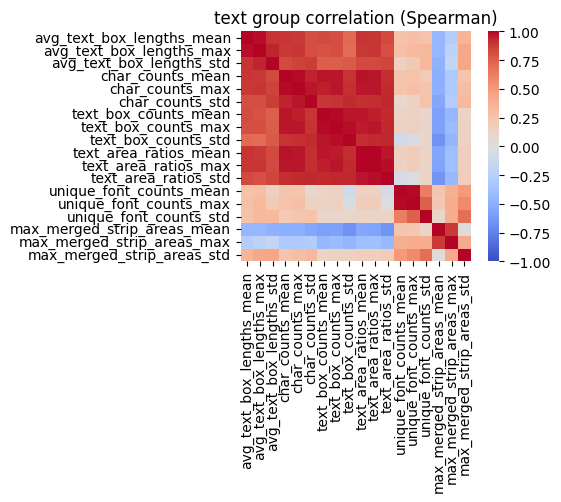

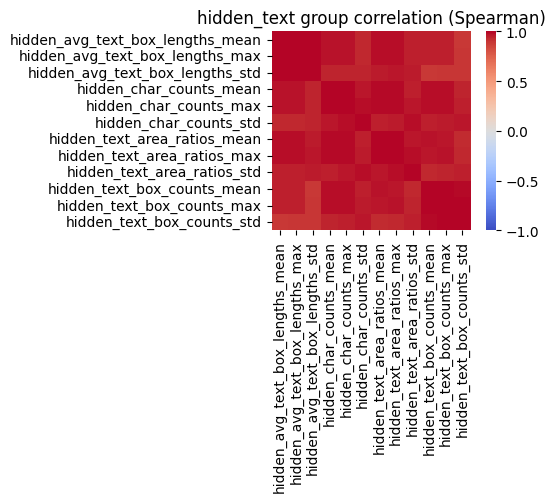

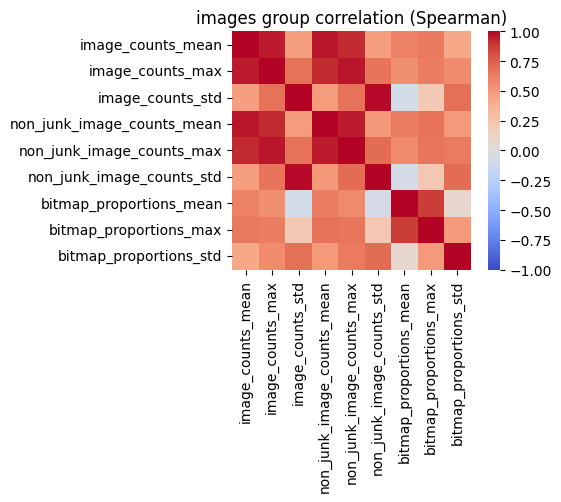

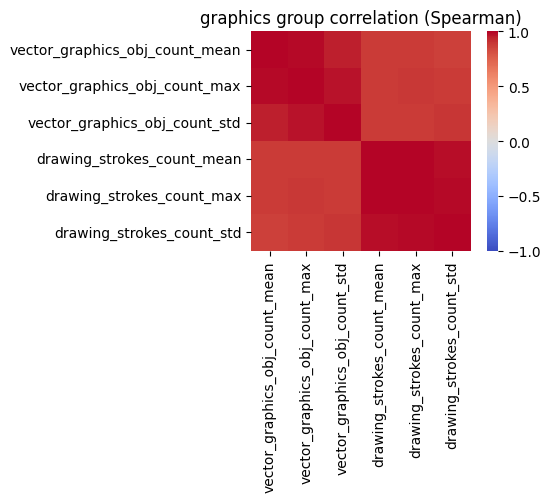

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
groups = {
    "text": text_features,
    "hidden_text": hidden_text_features,
    "images": image_features,
    "graphics": vector_features,
}

stats = ["mean", "max", "std"]


def plot_group_corr(group_name, corr_dict, vlim=1.0):
    corr = corr_dict[group_name]
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        corr, vmin=-vlim, vmax=vlim, center=0,
        cmap="coolwarm", annot=False, square=True
    )
    plt.title(f"{group_name} group correlation (Spearman)")
    plt.tight_layout()


corr_by_group = {}
for g, bases in groups.items():
    cols = [f"{b}_{s}" for b in bases for s in stats if f"{b}_{s}" in agg_df]
    corr_by_group[g] = agg_df[cols].corr(method="spearman")
    plot_group_corr(g, corr_by_group)
    plt.show()

In [17]:
import numpy as np

thr = 0.8
g = "images" 
corr = corr_by_group[g]

# 取上三角（不含对角线），按绝对值筛
mask = np.triu(np.ones(corr.shape, dtype=bool), k=1)
strong_pairs = (
    corr.where(mask)                # 上三角保留
        .stack()                    # 拉成长表
        .loc[lambda s: s.abs() > thr]  # 过滤
        .sort_values(key=abs, ascending=False)
)

print(strong_pairs)

image_counts_std            non_junk_image_counts_std     0.985859
image_counts_mean           non_junk_image_counts_mean    0.962360
image_counts_max            non_junk_image_counts_max     0.961285
image_counts_mean           image_counts_max              0.960784
non_junk_image_counts_mean  non_junk_image_counts_max     0.960494
image_counts_mean           non_junk_image_counts_max     0.924444
image_counts_max            non_junk_image_counts_mean    0.923991
bitmap_proportions_mean     bitmap_proportions_max        0.868737
dtype: float64


## 分桶

In [18]:
bins = [0, 0.3, 0.7, 1.0]
labels = ["low", "mid", "high"]
agg_df["prob_bucket"] = pd.cut(agg_df["ocr_probability"],
                           bins=bins, labels=labels, include_lowest=True)

In [19]:
agg_df["prob_bucket"].value_counts()

prob_bucket
mid     1943
high    1799
low     1552
Name: count, dtype: int64

In [20]:
agg_mid = agg_df[agg_df["prob_bucket"] == "mid"]
agg_mid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1943 entries, 1 to 5294
Data columns (total 57 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   file_name                             1943 non-null   object  
 1   ocr_probability                       1943 non-null   float64 
 2   file_size_bytes                       1943 non-null   int64   
 3   file_size_MB                          1943 non-null   float64 
 4   size_bucket                           1943 non-null   object  
 5   need_ocr_old_threshold                1943 non-null   bool    
 6   page_count                            1943 non-null   int64   
 7   num_pages_successfully_sampled        1943 non-null   float64 
 8   garbled_text_ratio                    1943 non-null   float64 
 9   is_form                               1943 non-null   object  
 10  creator_or_producer_is_known_scanner  1943 non-null   object  
 11  avg_text_

/var/folders/8h/qygchvl97sd_mr0kglftbvp80000gn/T/ipykernel_22719/946820684.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = agg_df.groupby("prob_bucket")["page_count"].describe()
/var/folders/8h/qygchvl97sd_mr0kglftbvp80000gn/T/ipykernel_22719/946820684.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  q = agg_df.groupby("prob_bucket")["page_count"].quantile(


              count       mean        std  min  25%  50%   75%    max
prob_bucket                                                          
low          1552.0  18.672036  45.860735  1.0  2.0  5.0  16.0  687.0
mid          1943.0  18.955739  61.370916  1.0  1.0  1.0   9.0  809.0
high         1799.0  23.340745  63.148509  1.0  2.0  4.0  13.5  887.0

quantiles 0.1/0.5/0.9:
              0.1  0.5   0.9
prob_bucket                
low          1.0  5.0  41.9
mid          1.0  1.0  40.0
high         1.0  4.0  60.0


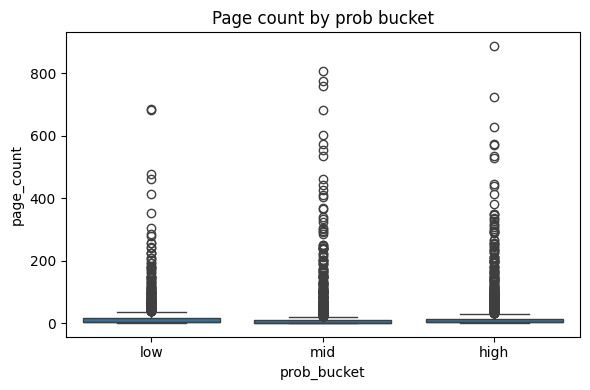

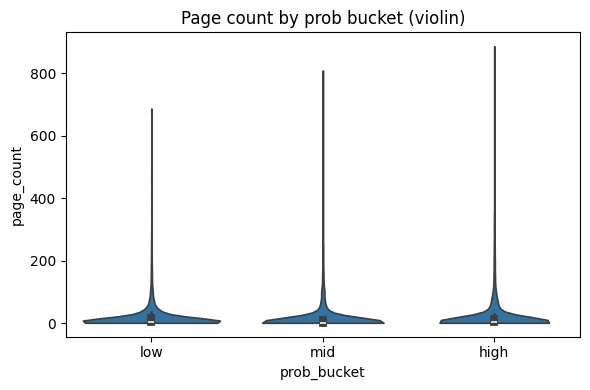

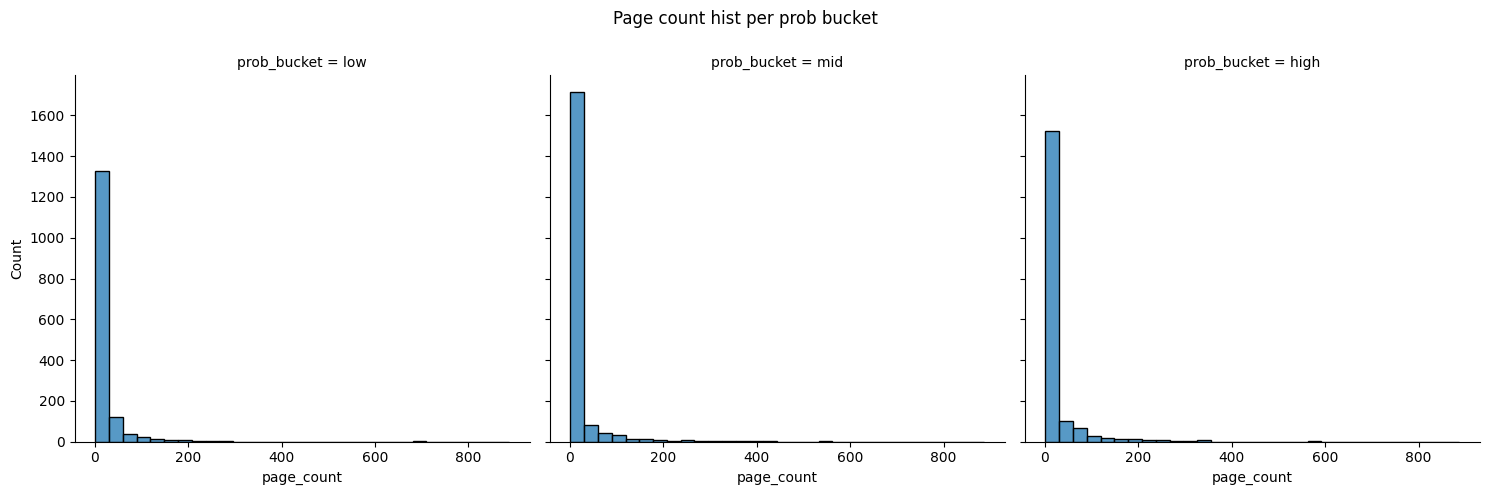

In [21]:
# 1) 基本统计
import matplotlib.pyplot as plt
import seaborn as sns
stats = agg_df.groupby("prob_bucket")["page_count"].describe()
q = agg_df.groupby("prob_bucket")["page_count"].quantile(
    [0.1, 0.5, 0.9]).unstack()

print(stats)
print("\nquantiles 0.1/0.5/0.9:\n", q)

# 2) 箱线图/小提琴

plt.figure(figsize=(6, 4))
sns.boxplot(data=agg_df, x="prob_bucket",
            y="page_count", order=["low", "mid", "high"])
plt.title("Page count by prob bucket")
plt.tight_layout()

plt.figure(figsize=(6, 4))
sns.violinplot(data=agg_df, x="prob_bucket", y="page_count",
               order=["low", "mid", "high"], cut=0)
plt.title("Page count by prob bucket (violin)")
plt.tight_layout()

# 3) 每桶的直方图/核密度
g = sns.displot(
    data=agg_df, x="page_count", col="prob_bucket",
    col_order=["low", "mid", "high"], kind="hist", bins=30, facet_kws={"sharex": False}
)
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Page count hist per prob bucket")
plt.show()

             count      mean       std       min       25%       50%  \
quadrant                                                               
large_few    335.0  0.613982  0.248705  0.101259  0.430447  0.691017   
large_many   148.0  0.626181  0.244354  0.101444  0.438670  0.713193   
small_few   4708.0  0.512941  0.270373  0.100024  0.243939  0.538354   
small_many   103.0  0.465913  0.241902  0.103607  0.211586  0.487842   

                 75%       max  
quadrant                        
large_few   0.825196  0.897118  
large_many  0.841801  0.897591  
small_few   0.780136  0.899669  
small_many  0.660106  0.885112  

计数:
 quadrant
small_few     4708
large_few      335
large_many     148
small_many     103
Name: count, dtype: int64


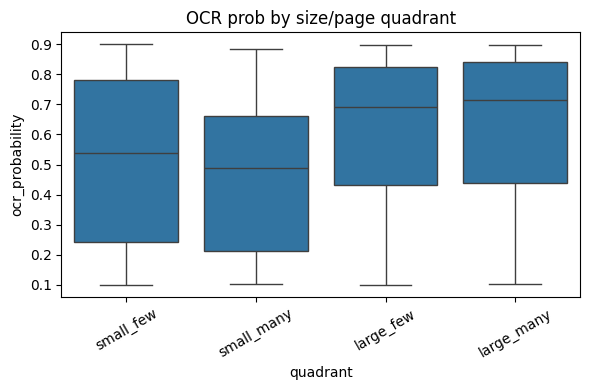

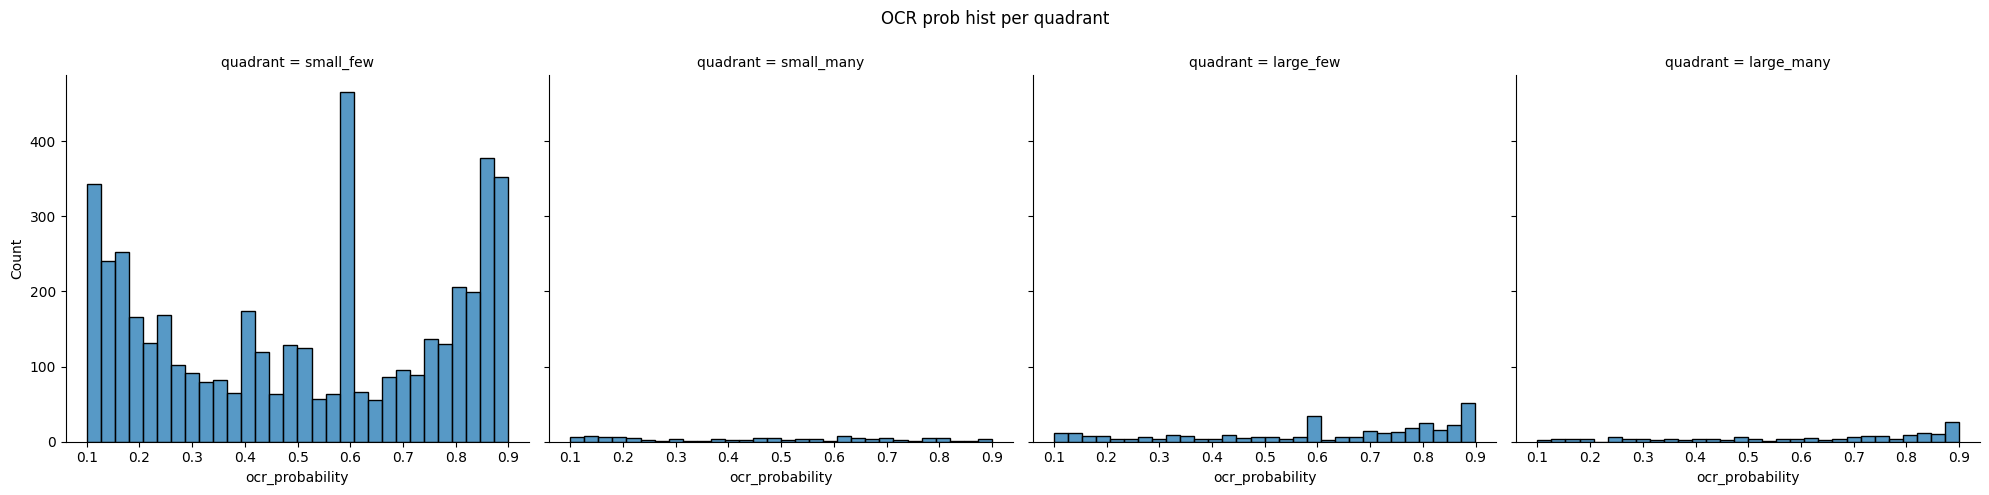

In [22]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1) 二分并组合
agg_df["size_bin"] = np.where(agg_df["file_size_MB"] <= 5, "small", "large")
agg_df["page_bin"] = np.where(agg_df["page_count"] <= 100, "few",   "many")

agg_df["quadrant"] = (
    agg_df["size_bin"] + "_" + agg_df["page_bin"]
)  # small_few / small_many / large_few / large_many

# 2) 分布/统计
print(agg_df.groupby("quadrant")["ocr_probability"].describe())
print("\n计数:\n", agg_df["quadrant"].value_counts())

# 3) 画图
plt.figure(figsize=(6, 4))
sns.boxplot(data=agg_df, x="quadrant", y="ocr_probability",
            order=["small_few", "small_many", "large_few", "large_many"])
plt.xticks(rotation=30)
plt.title("OCR prob by size/page quadrant")
plt.tight_layout()

g = sns.displot(
    data=agg_df, x="ocr_probability", col="quadrant",
    col_order=["small_few", "small_many", "large_few", "large_many"],
    kind="hist", bins=30, facet_kws={"sharex": True}
)
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("OCR prob hist per quadrant")
plt.show()

### 异常值

In [14]:
import numpy as np
from scipy.stats import median_abs_deviation

agg_cols = [c for c in agg_df.columns if c.endswith(('_mean', '_max', '_std'))]

# 1) Robust z-score (median + MAD)


def mad_z(x):
    med = np.median(x)
    mad = median_abs_deviation(x, nan_policy='omit')
    return (x - med) / (1.4826 * mad)  # 1.4826 makes MAD comparable to std


z = agg_df[agg_cols].apply(mad_z)
row_outliers = (z.abs() > 4)  # tweak 3–5 as needed
flag_mask = row_outliers.any(axis=1)

suspicious = agg_df.loc[flag_mask]
suspicious_cols = row_outliers.columns[row_outliers.any()]
suspicious_rows = agg_df.loc[flag_mask, suspicious_cols]

print(f"Flagged {flag_mask.sum()} rows")
display(suspicious_rows.head())

Flagged 4073 rows


,avg_text_box_lengths_mean,avg_text_box_lengths_max,bitmap_proportions_mean,bitmap_proportions_max,char_counts_mean,char_counts_max,drawing_strokes_count_mean,drawing_strokes_count_max,hidden_avg_text_box_lengths_mean,hidden_avg_text_box_lengths_max,...,non_junk_image_counts_mean,non_junk_image_counts_max,text_area_ratios_mean,text_area_ratios_max,text_box_counts_mean,text_box_counts_max,unique_font_counts_mean,unique_font_counts_max,vector_graphics_obj_count_mean,vector_graphics_obj_count_max
0,420.405515,509.823406,0.000000,0.000000,928.625,1598.0,86.500000,179.0,0.0,0.0,...,0.000000,0.0,0.440599,0.925951,239.125000,438.0,0.0,0.0,15.500000,32.0
1,2977.017143,2977.021306,0.975017,0.976690,53.000,53.0,2.000000,2.0,0.0,0.0,...,1.000000,1.0,0.002934,0.003048,1.000000,1.0,1.0,1.0,1.000000,1.0
2,18353.311160,36485.157034,0.489642,1.000000,2881.000,4876.0,1.333333,3.0,0.0,0.0,...,1.333333,2.0,0.585127,1.045612,9.333333,16.0,5.0,8.0,1.333333,2.0
3,0.000000,0.000000,1.903675,1.903675,0.000,0.0,0.000000,0.0,0.0,0.0,...,1.000000,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
4,1487.432713,1487.432713,0.807935,0.807935,145.000,145.0,0.000000,0.0,0.0,0.0,...,6.000000,6.0,0.012275,0.012275,4.000000,4.0,1.0,1.0,0.000000,0.0


In [15]:
q1 = agg_df[agg_cols].quantile(0.25)
q3 = agg_df[agg_cols].quantile(0.75)
iqr = q3 - q1
low = q1 - 3 * iqr
high = q3 + 3 * iqr

iqr_mask = ((agg_df[agg_cols] < low) | (agg_df[agg_cols] > high)).any(axis=1)
agg_df.loc[iqr_mask, agg_cols].head()

,avg_text_box_lengths_mean,avg_text_box_lengths_max,avg_text_box_lengths_std,bitmap_proportions_mean,bitmap_proportions_max,bitmap_proportions_std,char_counts_mean,char_counts_max,char_counts_std,drawing_strokes_count_mean,...,text_area_ratios_std,text_box_counts_mean,text_box_counts_max,text_box_counts_std,unique_font_counts_mean,unique_font_counts_max,unique_font_counts_std,vector_graphics_obj_count_mean,vector_graphics_obj_count_max,vector_graphics_obj_count_std
0,420.405515,509.823406,116.836870,0.000000,0.000000,0.000000,928.625,1598.0,454.755802,86.500000,...,0.310347,239.125000,438.0,126.467881,0.0,0.0,0.000000,15.500000,32.0,11.747340
1,2977.017143,2977.021306,0.008327,0.975017,0.976690,0.003345,53.000,53.0,0.000000,2.000000,...,0.000223,1.000000,1.0,0.000000,1.0,1.0,0.000000,1.000000,1.0,0.000000
2,18353.311160,36485.157034,18243.586712,0.489642,1.000000,0.444660,2881.000,4876.0,2555.893386,1.333333,...,0.533833,9.333333,16.0,8.326664,5.0,8.0,4.358899,1.333333,2.0,1.154701
4,1487.432713,1487.432713,NaN,0.807935,0.807935,NaN,145.000,145.0,NaN,0.000000,...,NaN,4.000000,4.0,NaN,1.0,1.0,NaN,0.000000,0.0,NaN
5,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,4.0,4.0,0.000000,0.000000,0.0,0.000000


In [16]:
agg_cols = [c for c in agg_df.columns if c.endswith(('_mean', '_max', '_std'))]
iqr = agg_df[agg_cols].quantile(0.75) - agg_df[agg_cols].quantile(0.25)
keep_cols = iqr[iqr > 1e-6].index  # 去掉近乎常数列
q1 = agg_df[keep_cols].quantile(0.25)
q3 = agg_df[keep_cols].quantile(0.75)
iqr = q3 - q1
low = q1 - 3 * iqr
high = q3 + 3 * iqr
iqr_mask = ((agg_df[keep_cols] < low) | (agg_df[keep_cols] > high)).any(axis=1)

In [18]:
iqr_mask.sum()

np.int64(3236)

In [19]:
per_col = ((agg_df[keep_cols] < low) | (agg_df[keep_cols]
           > high)).sum().sort_values(ascending=False)
print(per_col.head(10))

hidden_text_box_counts_mean         1128
hidden_text_box_counts_max          1092
hidden_avg_text_box_lengths_max     1018
hidden_avg_text_box_lengths_mean     982
hidden_char_counts_mean              963
drawing_strokes_count_max            888
text_box_counts_mean                 827
hidden_text_area_ratios_mean         823
hidden_char_counts_max               810
text_box_counts_max                  807
dtype: int64
